--- Bắt đầu trực quan hóa dữ liệu ---


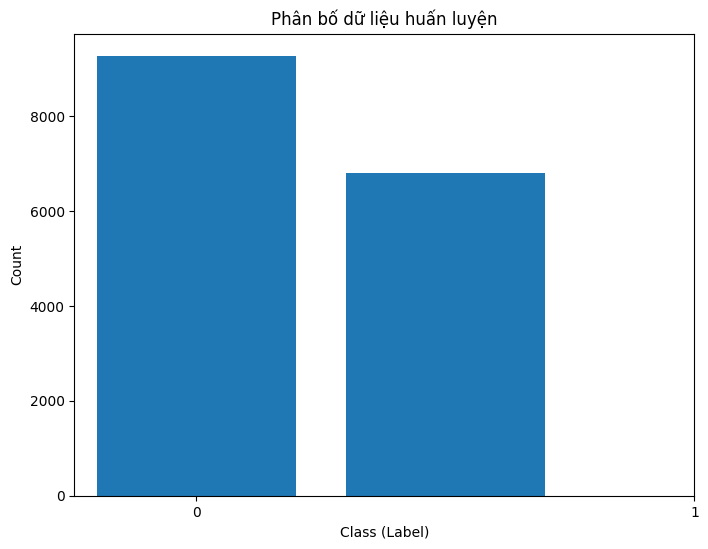

Đã lưu biểu đồ phân bố dữ liệu vào data_distribution.png
--- Kết thúc trực quan hóa dữ liệu ---

--- Bắt đầu quá trình huấn luyện ---
Đang tải dữ liệu từ /content/train.crash...
Số lượng mẫu dữ liệu hợp lệ: 16086
Khởi tạo Tokenizer và Model BERT...
Sử dụng thiết bị: cpu
Đang xử lý văn bản và tạo nhãn...
Số lượng văn bản để tạo embedding: 16086
Đang tạo embedding từ BERT cho toàn bộ dữ liệu (có thể mất thời gian)...
Chia dữ liệu thành tập huấn luyện và tập kiểm tra...
Số lượng mẫu huấn luyện: 12868, Số lượng mẫu kiểm tra: 3218
Huấn luyện mô hình SVC...
Độ chính xác trên tập kiểm tra: 0.8297

Ma trận nhầm lẫn (Confusion Matrix):
[[1555  301]
 [ 247 1115]]


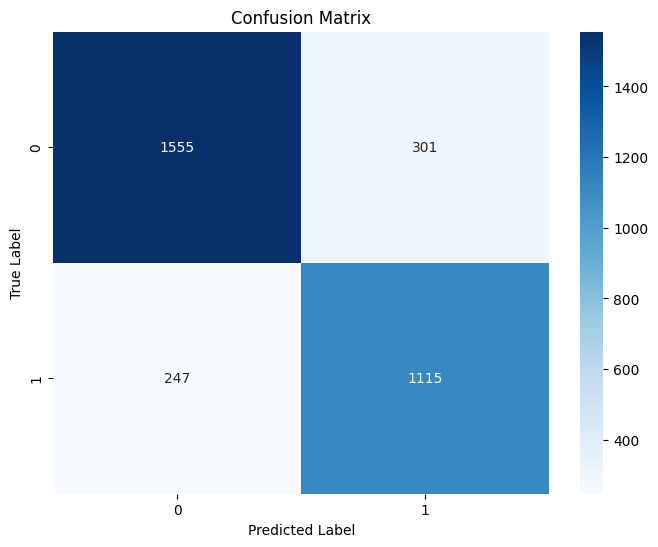

Đã hiển thị ma trận nhầm lẫn.

Đã lưu model SVM đã huấn luyện vào /content/best_model.pkl

--- Bắt đầu kiểm tra phân loại câu ---
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): đẹp quá
Kết quả: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): phù hợp với giá tiền
Kết quả: Bình luận tiêu cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): đắt nhưng đẹp 
Kết quả: Bình luận tích cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): phù hợp với lứa tuổi trẻ trung, shop đỉnh quá
Kết quả: Bình luận tiêu cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): xấu xí quá 
Kết quả: Bình luận tiêu cực!
Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): exit
--- Chương trình kết thúc ---


In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC
# from sklearn.feature_extraction.text import TfidfVectorizer # Không dùng trong phiên bản BERT
# from sklearn.model_selection import GridSearchCV, cross_val_score # Không dùng trong phiên bản này
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # Thêm import này
import seaborn as sns                   # Thêm import này

PATH_DATA = "/content/train.crash" # Đặt tên biến rõ ràng hơn

# Load và xử lý dữ liệu
class DataSource:
    def _load_raw_data(self, filename, is_train=True):
        a = []
        b = []
        regex = 'train_' if is_train else 'test_' # Giả sử file test cũng có cấu trúc tương tự
        # Kiểm tra file tồn tại
        try:
            with open(filename, "r", encoding="utf-8") as file:
                for line in file:
                    if regex in line: # Dòng chứa ID
                        if a: # Nếu a không rỗng, tức là đã có sample trước đó
                            b.append(a)
                        a = [line] # Bắt đầu sample mới
                    elif line.strip(): # Các dòng nội dung review, bỏ qua dòng trống
                        a.append(line)
                    # Dòng cuối của sample (nhãn) sẽ được xử lý khi gặp ID tiếp theo hoặc cuối file
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file {filename}")
            return []

        if a: # Thêm sample cuối cùng
            b.append(a)
        return b[1:] if b and regex in b[0][0] else b # Trả về b[1:] nếu phần tử đầu tiên là dòng ID không hoàn chỉnh, hoặc b nếu nó bắt đầu đúng

    def _create_row(self, sample_lines, is_train=True):
        d = {}
        if not sample_lines:
            return None

        d['id'] = sample_lines[0].strip()

        # Ghép các dòng review, dòng cuối cùng có thể là nhãn
        if is_train:
            if len(sample_lines) < 2: # Cần ít nhất ID và nhãn
                 print(f"Cảnh báo: Sample không đủ dòng: {sample_lines}")
                 return None
            # Dòng cuối là nhãn, các dòng ở giữa là review
            review_lines = sample_lines[1:-1]
            label_line = sample_lines[-1].strip()
            if not label_line.isdigit(): # Nếu dòng cuối không phải số (nhãn)
                print(f"Cảnh báo: Nhãn không hợp lệ cho sample {d['id']}: '{label_line}'. Có thể review bị thiếu dòng nhãn.")
                # Coi tất cả là review nếu không có nhãn rõ ràng
                review_lines = sample_lines[1:]
                d['label'] = -1 # Hoặc một giá trị mặc định cho nhãn không xác định
            else:
                d['label'] = int(label_line)
        else: # Dữ liệu test không có nhãn
            review_lines = sample_lines[1:]

        d['review'] = "".join(clause.strip() for clause in review_lines)
        if not d['review']: # Nếu review rỗng sau khi xử lý
            print(f"Cảnh báo: Review rỗng cho ID {d['id']}")
        return d

    def load_data(self, filename, is_train=True):
        raw_samples = self._load_raw_data(filename, is_train)
        processed_rows = []
        for sample_lines in raw_samples:
            row = self._create_row(sample_lines, is_train)
            if row: # Chỉ thêm nếu row được tạo thành công
                processed_rows.append(row)
        if not processed_rows:
            print(f"Không có dữ liệu nào được tải từ {filename}. Vui lòng kiểm tra định dạng file.")
        return processed_rows

# Trực quan hóa dữ liệu
def visualize_data(file_path):
    ds = DataSource()
    # Sử dụng is_train=True vì file train.crash chứa nhãn
    data_list = ds.load_data(file_path, is_train=True)
    if not data_list:
        print("Không có dữ liệu để trực quan hóa.")
        return

    train_data = pd.DataFrame(data_list)
    if 'label' not in train_data.columns or train_data.empty:
        print("Dữ liệu không có cột 'label' hoặc rỗng sau khi tải.")
        return

    # Loại bỏ các nhãn không hợp lệ (ví dụ -1 nếu có) trước khi vẽ
    valid_labels = train_data[train_data['label'] != -1]['label']
    if valid_labels.empty:
        print("Không có nhãn hợp lệ để trực quan hóa.")
        return

    plt.figure(figsize=(8,6))
    plt.hist(valid_labels.to_numpy(), bins=len(valid_labels.unique()), rwidth=0.8, align='left') # Điều chỉnh bins
    plt.xlabel("Class (Label)")
    plt.ylabel("Count")
    plt.title("Phân bố dữ liệu huấn luyện")
    plt.xticks(sorted(valid_labels.unique())) # Hiển thị các giá trị nhãn trên trục x
    plt.savefig('data_distribution.png')
    plt.show()
    print("Đã lưu biểu đồ phân bố dữ liệu vào data_distribution.png")


# Tiền xử lý văn bản
class Util:
    dict_replace = {
        "ship": "vận chuyển","shop": "cửa hàng","m": "mình","mik":"mình","ko":"không","k":"không","kh":"không","khong":"không","kg":"không","khg":"không","tl":"trả lời",
"rep":"trả lời","r":"rồi","fb":"facebook","face":"faceook","thanks":"cảm ơn","thank":"cảm ơn","tks":"cảm ơn","tk":"cảm ơn","ok":"tốt","oki":"tốt","okie":"tốt","sp":"sản phẩm",
"dc":"được","vs":"với","đt":"điện thoại","thjk":"thích","thik":"thích","qá":"quá","trể":"trễ","bgjo":"bao giờ","h":"giờ","qa":"quá","dep":"đẹp","xau":"xấu","ib":"nhắn tin",
"cute":"dễ thương","sz":"size","good":"tốt","god":"tốt","bt":"bình thường"
    }

    def remove_redundant(self, text):
        if not isinstance(text, str): # Xử lý trường hợp text không phải là string
            return ""
        return re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    def normalize(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        words = text.split()
        words = [self.dict_replace.get(w, w) for w in words]
        return " ".join(words)

    def process_text(self, text):
        text = self.remove_redundant(text)
        text = self.normalize(text)
        return text

# Lớp Training được đưa ra ngoài Util
class Training:
    def __init__(self, data_source_instance: DataSource, file_path: str):
        self.path = file_path
        self.util = Util()

        print(f"Đang tải dữ liệu từ {self.path}...")
        raw_data_list = data_source_instance.load_data(self.path, is_train=True)
        if not raw_data_list:
            raise ValueError(f"Không thể tải dữ liệu từ {self.path}. Dữ liệu rỗng.")

        self.data = pd.DataFrame(raw_data_list)

        if 'review' not in self.data.columns or 'label' not in self.data.columns:
            raise ValueError("Dữ liệu DataFrame phải có cột 'review' và 'label'.")

        # Loại bỏ các hàng có nhãn không hợp lệ (ví dụ: -1) hoặc review rỗng
        self.data = self.data[self.data['label'] != -1]
        self.data = self.data.dropna(subset=['review'])
        self.data = self.data[self.data['review'].str.strip() != '']

        if self.data.empty:
            raise ValueError("Không có dữ liệu hợp lệ sau khi làm sạch.")

        print(f"Số lượng mẫu dữ liệu hợp lệ: {len(self.data)}")
        print("Khởi tạo Tokenizer và Model BERT...")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert_model.to(self.device)
        self.bert_model.eval() # Đặt model ở chế độ eval cho embedding extraction
        print(f"Sử dụng thiết bị: {self.device}")

    def get_bert_embedding(self, sentence: str):
        inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    def train_model(self):
        if self.data.empty:
            print("Không có dữ liệu để huấn luyện.")
            return None, None

        print("Đang xử lý văn bản và tạo nhãn...")
        texts = self.data['review'].apply(self.util.process_text).tolist()
        labels = self.data['label'].tolist()

        if not texts or not labels:
            print("Không có văn bản hoặc nhãn sau khi xử lý.")
            return None, None

        print(f"Số lượng văn bản để tạo embedding: {len(texts)}")

        print("Đang tạo embedding từ BERT cho toàn bộ dữ liệu (có thể mất thời gian)...")
        embeddings = [self.get_bert_embedding(text) for text in texts]
        embeddings_array = np.array(embeddings)

        if embeddings_array.ndim == 1: # Trường hợp chỉ có 1 sample sau khi filter
            print("Chỉ có 1 sample, không thể chia train/test. Cần nhiều dữ liệu hơn.")
            # Hoặc xử lý trường hợp này theo cách khác (ví dụ: không huấn luyện)
            # return None, None
            # For now, let's try to reshape if it's a single embedding for a single sample
            if embeddings_array.shape[0] > 0 and len(texts) == 1: # A single embedding vector
                 embeddings_array = embeddings_array.reshape(1, -1)
            else: # Something is wrong, possibly all embeddings failed or were empty
                 print("Lỗi tạo embedding hoặc không có embedding nào được tạo.")
                 return None, None


        print("Chia dữ liệu thành tập huấn luyện và tập kiểm tra...")

        # Stratify chỉ hoạt động nếu có ít nhất 2 mẫu cho mỗi lớp
        unique_labels, counts = np.unique(labels, return_counts=True)
        stratify_option = None
        if len(unique_labels) > 1 and all(c >= 2 for c in counts): # Cần ít nhất 2 mẫu mỗi lớp cho stratify
            stratify_option = labels
        else:
            print("Không đủ mẫu cho mỗi lớp để thực hiện stratify, sẽ chia không stratify.")
            if len(unique_labels) == 1:
                print(f"Cảnh báo: Dữ liệu chỉ chứa 1 lớp ({unique_labels[0]}). Model có thể không học được gì hữu ích.")


        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_array, labels, test_size=0.2, random_state=42, stratify=stratify_option
        )

        if len(X_train) == 0 or len(X_test) == 0:
            print("Tập huấn luyện hoặc tập kiểm tra rỗng sau khi chia. Cần nhiều dữ liệu hơn.")
            return None, None

        print(f"Số lượng mẫu huấn luyện: {len(X_train)}, Số lượng mẫu kiểm tra: {len(X_test)}")
        print("Huấn luyện mô hình SVC...")
        model = SVC(kernel='linear', probability=True) # probability=True hữu ích cho một số tác vụ
        model.fit(X_train, y_train)

        accuracy = model.score(X_test, y_test)
        print(f"Độ chính xác trên tập kiểm tra: {accuracy:.4f}")

        # Lấy dự đoán trên tập kiểm tra để tạo ma trận nhầm lẫn
        y_pred = model.predict(X_test)

        # In ma trận nhầm lẫn
        print("\nMa trận nhầm lẫn (Confusion Matrix):")
        # Đảm bảo labels cho confusion_matrix là các lớp mà model đã thấy
        # model.classes_ chứa các nhãn theo thứ tự SVC đã học
        class_labels = model.classes_
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        print(cm)

        # Hiển thị ma trận nhầm lẫn bằng heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()
        print("Đã hiển thị ma trận nhầm lẫn.")

        return model, None  # Không cần vectorizer nữa

# Hàm classify_sentence được đưa ra ngoài lớp
def classify_sentence(model_path: str, sentence: str, bert_model_instance: BertModel,
                      tokenizer_instance: BertTokenizer, device: torch.device):
    try:
        svc_model = joblib.load(model_path)
    except FileNotFoundError:
        return f"Lỗi: Không tìm thấy model đã lưu tại {model_path}"
    except Exception as e:
        return f"Lỗi khi tải model: {e}"

    util_processor = Util() # Util không có trạng thái, có thể tạo mới
    processed_text = util_processor.process_text(sentence)

    if not processed_text.strip():
        return "Văn bản rỗng sau khi tiền xử lý."

    inputs = tokenizer_instance(processed_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    bert_model_instance.eval() # Đảm bảo model ở chế độ eval
    with torch.no_grad():
        outputs = bert_model_instance(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy().reshape(1, -1)

    predicted_label = svc_model.predict(embedding)[0]

    # Giả định: 0 = Tích cực, 1 = Tiêu cực. Cần xác nhận điều này dựa trên dữ liệu train.crash
    # Hoặc dựa vào svc_model.classes_ nếu bạn muốn linh hoạt hơn
    # Ví dụ: class_map = {0: "Tích cực", 1: "Tiêu cực"} (nếu classes_ là [0,1])

    # Logic này dựa trên giả định phổ biến, bạn cần điều chỉnh nếu ý nghĩa nhãn khác
    if predicted_label == 1: # Giả sử nhãn 1 là tiêu cực
        return "Bình luận tiêu cực!"
    elif predicted_label == 0: # Giả sử nhãn 0 là tích cực
        return "Bình luận tích cực!"
    else: # Cho các trường hợp nhãn khác nếu có
        return f"Bình luận được phân loại là: {predicted_label}"


if __name__ == '__main__':
    # 1. Khởi tạo DataSource
    ds = DataSource()

    # 2. Trực quan hóa dữ liệu (nên thực hiện trước khi huấn luyện để hiểu dữ liệu)
    print("--- Bắt đầu trực quan hóa dữ liệu ---")
    visualize_data(PATH_DATA)
    print("--- Kết thúc trực quan hóa dữ liệu ---\n")

    # 3. Huấn luyện mô hình
    print("--- Bắt đầu quá trình huấn luyện ---")
    try:
        training_instance = Training(ds, PATH_DATA) # Truyền instance DataSource và đường dẫn
        model_svm, _ = training_instance.train_model()

        if model_svm:
            # 4. Lưu model SVM
            model_save_path = '/content/best_model.pkl'
            joblib.dump(model_svm, model_save_path)
            print(f"\nĐã lưu model SVM đã huấn luyện vào {model_save_path}")

            # 5. Tải lại model và tokenizer, bert_model để kiểm tra (hoặc dùng lại từ training_instance)
            print("\n--- Bắt đầu kiểm tra phân loại câu ---")
            # Sử dụng lại tokenizer và bert_model từ training_instance để nhất quán
            # Không cần tải lại BertModel và Tokenizer nếu chúng không thay đổi
            loaded_tokenizer = training_instance.tokenizer
            loaded_bert_model = training_instance.bert_model
            # Device cũng lấy từ training_instance
            device_for_classification = training_instance.device

            while True:
                text_input = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ").strip()
                if text_input.lower() == "exit":
                    break
                if not text_input:
                    print("Vui lòng nhập một câu.")
                    continue

                classification_result = classify_sentence(model_save_path,
                                                          text_input,
                                                          loaded_bert_model,
                                                          loaded_tokenizer,
                                                          device_for_classification)
                print(f"Kết quả: {classification_result}")
        else:
            print("Huấn luyện model không thành công, bỏ qua phần kiểm tra.")

    except ValueError as ve:
        print(f"Lỗi cấu hình hoặc dữ liệu: {ve}")
    except Exception as e:
        print(f"Đã xảy ra lỗi không mong muốn trong quá trình huấn luyện hoặc phân loại: {e}")

    print("--- Chương trình kết thúc ---")

In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from transformers import BertTokenizer, BertModel
import torch
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [ ]:
# Load và xử lý dữ liệu
class DataSource:
    def _load_raw_data(self, filename, is_train=True):
        a = []
        b = []
        regex = 'train_' if is_train else 'test_'
        with open(filename, "r", encoding="utf-8") as file:
            for line in file:
                if regex in line:
                    b.append(a)
                    a = [line]
                elif line != '\n':
                    a.append(line)
        b.append(a)
        return b[1:]

    def _create_row(self, sample, is_train=True):
        d = {'id': sample[0].strip()}
        review = "".join(clause.strip() for clause in sample[1:-1])
        d['review'] = review
        if is_train:
            d['label'] = int(sample[-1].strip())
        return d

    def load_data(self, filename, is_train=True):
        raw_data = self._load_raw_data(filename, is_train)
        return [self._create_row(row, is_train) for row in raw_data]


In [ ]:

# Trực quan hóa dữ liệu
def visualize_data(path):
    ds = DataSource()
    train_data = pd.DataFrame(ds.load_data(path))
    plt.hist(train_data.label.to_numpy(), rwidth=1, align='left')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Phân bố dữ liệu")
    plt.savefig('data_distribution.png')
PATH = "/content/train.crash"
visualize_data(PATH)

In [ ]:

# Tiền xử lý văn bản
class Util:
    dict_replace = {
        "ship": "vận chuyển","shop": "cửa hàng","m": "mình","mik":"mình","ko":"không","k":"không","kh":"không","khong":"không","kg":"không","khg":"không","tl":"trả lời",
"rep":"trả lời","r":"rồi","fb":"facebook","face":"faceook","thanks":"cảm ơn","thank":"cảm ơn","tks":"cảm ơn","tk":"cảm ơn","ok":"tốt","oki":"tốt","okie":"tốt","sp":"sản phẩm",
"dc":"được","vs":"với","đt":"điện thoại","thjk":"thích","thik":"thích","qá":"quá","trể":"trễ","bgjo":"bao giờ","h":"giờ","qa":"quá","dep":"đẹp","xau":"xấu","ib":"nhắn tin",
"cute":"dễ thương","sz":"size","good":"tốt","god":"tốt","bt":"bình thường"
    }

    def remove_redundant(self, text):
        return re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    def normalize(self, text):
        text = text.lower()
        words = text.split()
        words = [self.dict_replace.get(w, w) for w in words]
        return " ".join(words)

    def process_text(self, text):
        text = self.remove_redundant(text)
        return self.normalize(text)

In [ ]:
class Training:
    def __init__(self, path):
        self.path = path
        self.util = Util()
        self.data = self.util.read_file(self.path)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def get_bert_embedding(self, sentence):
        inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        # Sử dụng embedding của CLS token
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def train_model(self):
        texts = self.data['text'].apply(self.util.process_text).tolist()
        labels = self.data['label'].tolist()

        # Tạo embedding từ BERT
        embeddings = [self.get_bert_embedding(text) for text in texts]

        X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
        model = SVC(kernel='linear')
        model.fit(X_train, y_train)
        print("Độ chính xác trên tập kiểm tra:", model.score(X_test, y_test))

        return model, None  # Không cần vectorizer nữa

In [ ]:
def classify_sentence(model_path, sentence, bert_model, tokenizer):
    model = joblib.load(model_path)
    processed_text = Util().process_text(sentence)

    inputs = tokenizer(processed_text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy().reshape(1, -1)

    label = model.predict(embedding)
    return "Bình luận tiêu cực!" if label[0] == 1 else "Bình luận tích cực!"


In [ ]:
if __name__ == '__main__':
    ds = DataSource()
    train_data = pd.DataFrame(ds.load_data(PATH))

    PATH = "/content/train.crash"
    visualize_data(PATH)

    training = Training(PATH)
    model, _ = training.train_model()

    # Lưu model
    joblib.dump(model, 'bert_svm_model.pkl')

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    while True:
        text = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ").strip()
        if text.lower() == "exit":
            break
        print(classify_sentence('/content/bert_svm_model.pkl', text, bert_model, tokenizer))
